In [1]:
import tensorflow as tf
import os
from parselmouth import Sound
import pathlib
import pandas as pd

In [24]:
def train_data():
    data_dir = os.path.join(os.curdir, "data")
    train_data_dir = os.path.join(data_dir, "test")
    list_files = lambda x,p: list(pathlib.Path(x).rglob(p))
    pd_filepath = [[str(i), 1] for i in list_files(train_data_dir, "*/PD/*.wav")]
    hc_filepath = [[str(i), 0] for i in list_files(train_data_dir, "*/HC/*.wav")]
    data = []
    data.extend(pd_filepath)
    data.extend(hc_filepath)
    df = pd.DataFrame(data=data, columns=["filename", "class"])
    return df

In [25]:
df = train_data()
wav_file_path = df["filename"][0]

In [26]:
from scipy.io import wavfile
import matplotlib.pyplot as plt

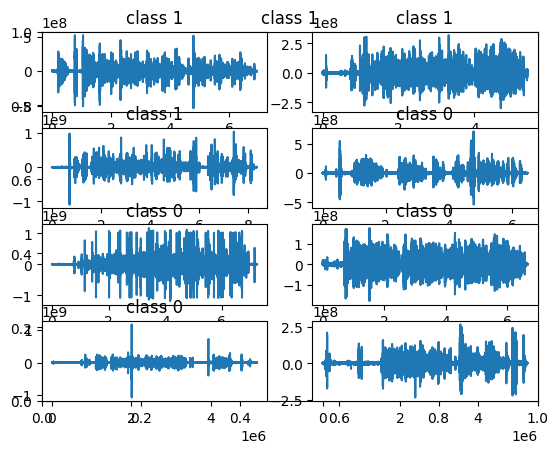

In [40]:
data = df.to_numpy()
for i, x in enumerate(data):
    freq, sound_value = wavfile.read(x[0])
    plt.title("class "+str(x[1]))
    plt.subplot(4, 2, i+1)
    plt.plot(range(len(sound_value)), sound_value)
plt.figure(8, figsize=(15,15))
plt.show()

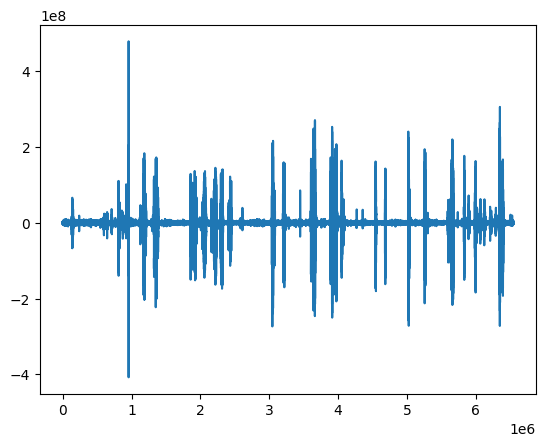

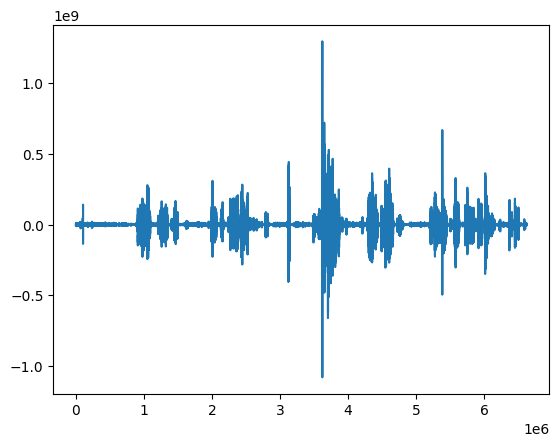

In [23]:
data = df.to_numpy()
for x in data[-2:]:
    freq, sound_value = wavfile.read(x[0])
    plt.plot(range(len(sound_value)), sound_value)
    plt.show()

In [5]:
freq, data = wavfile.read(wav_file_path)

In [6]:
print(freq, type(data))


44100 <class 'numpy.ndarray'>


In [8]:
n = len(data)

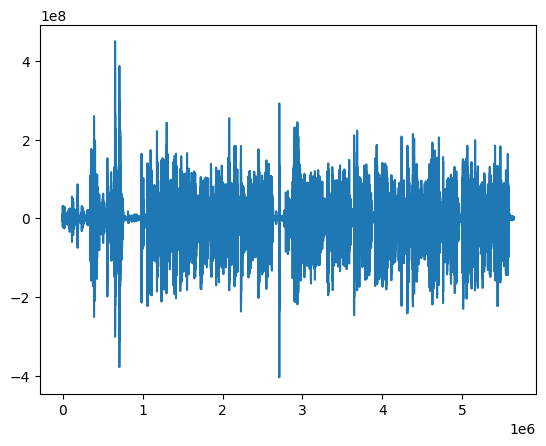

In [9]:
plt.plot(range(len(data)), data)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense
import numpy as np
import matplotlib.pyplot as plt

# Define a simple 1D CNN model in TensorFlow/Keras
def create_1d_cnn_model():
    inputs = Input(shape=(5641310, 1))
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = create_1d_cnn_model()
model.summary()

# Grad-CAM for 1D Convolutional Neural Networks
def grad_cam_1d(model, input_data, layer_name):
    grad_model = Model(inputs=[model.inputs],
                       outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_data)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)

    # Compute the guided gradients
    guided_grads = conv_outputs * grads

    # Average gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=1)

    # Build a map of each channel's contribution to the output
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Pass through ReLU
    cam = tf.maximum(cam, 0)

    # Normalize heatmap
    heatmap = (cam - tf.reduce_min(cam)) / (tf.reduce_max(cam) - tf.reduce_min(cam))

    return heatmap.numpy()[0]

# Create a random input data sample
input_data = data

# Generate Grad-CAM heatmap
layer_name = 'conv1d_1' # Specify the layer name for Grad-CAM
heatmap = grad_cam_1d(model, input_data, layer_name)

# Plot the heatmap
plt.plot(heatmap)
plt.title('Grad-CAM')
plt.ylabel('Importance')
plt.xlabel('Time Step')
plt.show()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5641310, 1)]      0         
                                                                 
 conv1d (Conv1D)             (None, 5641310, 16)       64        
                                                                 
 conv1d_1 (Conv1D)           (None, 5641310, 32)       1568      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 1698 (6.63 KB)
Trainable params: 1698 (6.63 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________

ValueError: Exception encountered when calling layer 'model_1' (type Functional).

Input 0 of layer "conv1d" is incompatible with the layer: expected min_ndim=3, found ndim=1. Full shape received: (5641310,)

Call arguments received by layer 'model_1' (type Functional):
  • inputs=tf.Tensor(shape=(5641310,), dtype=int32)
  • training=None
  • mask=None